In [16]:
%matplotlib inline

import sys
from pathlib import Path
import json

import geojson
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

sys.path.append("../forestry_yield_estimation")
import vistools, utils
from preprocessing import read_raw_polygons_data

pd.options.mode.chained_assignment = None
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.4)

data_path = Path("../data")
points_path = data_path / "points/export.csv"
polygons_path = data_path / "polygons/export.geojson"
output_path = Path("../report/img/eda")

In [2]:
df = pd.read_csv(points_path).rename(columns=str.lower)

# First Exploration

In [ ]:
df.info()

There are no missing values. Let's generate and look at a profile report of the data.

In [5]:
profile = ProfileReport(df)
#profile.to_notebook_iframe()

# Preprocessing

From this report we can see that some columns are safe to delete:

- constants: `ano_rodal`, `especie`, `regime`, `area_parce`
- redundant: `id_nucleo`, `id_predio`, `dcr_predio`, `programaci`
- not useful: `cd_uso_sol`, `nro_parcel`

Some should be kept and potentially renamed:

- `x`, `y` to `easting`, `northing`
- `vol_mdp8` to `volume`
- `dcr_nucleo` to `zone` with values "north" and "south"
- `rodal`
- `data_rodal` to `plant_date`
- `edad` to `age`
- `data_medic` to `date`

Some are unclear and should be asked about:

- `objetivo`
- `dapmed`
- `htdom`
- `g`
- `nfustes`, `nfustes8`
- `bloque`
- `mg`
- `htmed`, `htdom`

And some should be added for easier handling of the data:

- `lon`, `lat`

This basic preprocessing is implemented in `preprocessing.read_raw_points_data`

In [6]:
from preprocessing import read_raw_points_data
df = read_raw_points_data(data_path, epsg=32721)

# Choosing a zone

Now we can use this to define our aoi for the S1 images. Let's choose a nucleo among the two we have, based on the number of measurements per date and an estimation of how noisy those measurements are.

In [ ]:
df

In [10]:
# Measurements per year
(
    df
    .assign(year=df["date"].dt.year)
    .groupby("zone")
    ["year"]
    .value_counts()
    .unstack()
    .assign(Total=lambda df: df.sum(1))
    .T
    .astype("Int64")
)

zone,north,south
year,,
2013,103,151
2016,103,147
2017,<NA>,176
2018,144,<NA>
Total,350,474


In [12]:
print(_.to_markdown())

| year   | north   | south   |
|:-------|:--------|:--------|
| 2013   | 103     | 151     |
| 2016   | 103     | 147     |
| 2017   | <NA>    | 176     |
| 2018   | 144     | <NA>    |
| Total  | 350     | 474     |


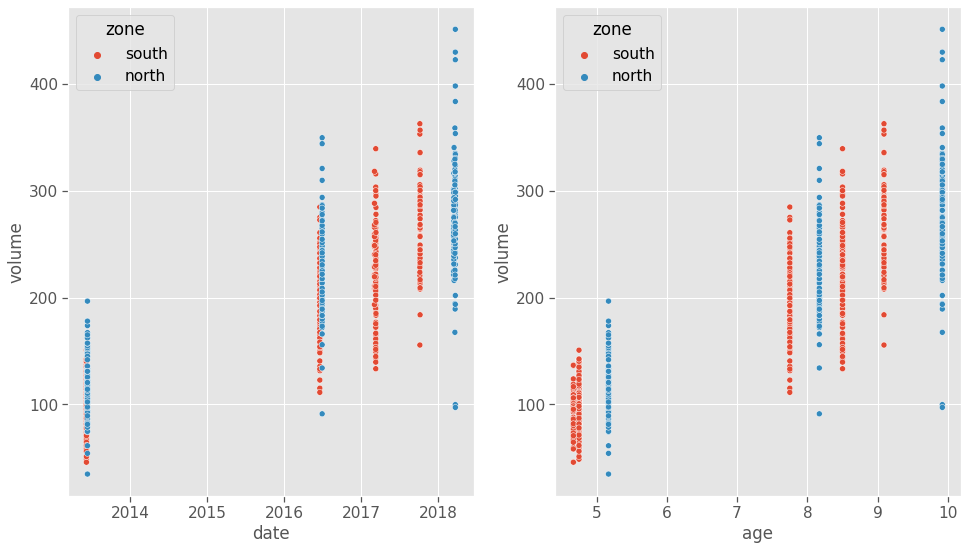

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
sns.scatterplot(data=df, hue="zone", x="date", y="volume", ax=axes[0])
sns.scatterplot(data=df, hue="zone", x="age", y="volume", ax=axes[1])
plt.savefig(output_path / "zone_comparison.png")

The two zones seem fairly complementary since they don't measure the same ages (and north goes up to an older age than south), but north also seems more noisy, with a higher number of outliers, and has less data points no matter the year (in total, it has 35% less data points).

It seems we should focus on the south zone (Pandule) for now.

# Defining AOIs

Now, let's define aois for the two zones.

In [35]:
for zone in ["south", "north"]:
    polygons, _ = read_raw_polygons_data(data_path, zone, offset_correction=(0, 0))
    
    # Get all the coords of polygons from the zone into a single array to extract bounding box
    coords = np.concatenate([
        np.array(np.concatenate(x)).squeeze()
        for x in polygons
    ])
    
    # Construct aoi as a table first
    aoi = pd.DataFrame({"min": coords.min(axis=0), "max": coords.max(axis=0)}, index=["easting", "northing"])
    aoi.loc["lon"], aoi.loc["lat"] = utils.utm_to_lonlat(aoi.loc["easting"], aoi.loc["northing"], epsg=32721)
    aoi["center"] = (aoi["max"] + aoi["min"])/2
    aoi["size"] = aoi["max"] - aoi["min"]
    
    print(f"ZONE: {zone}")
    print(aoi.applymap("{0:.5f}".format))
    print("")
    
    aoi.to_csv(data_path/f"aoi_{zone}.csv")
    aoi_json = {
        "type":"Polygon",
        "coordinates":[[
            [aoi.loc["lon", "min"],aoi.loc["lat", "min"]],
            [aoi.loc["lon", "min"],aoi.loc["lat", "max"]],
            [aoi.loc["lon", "max"],aoi.loc["lat", "max"]],
            [aoi.loc["lon", "max"],aoi.loc["lat", "min"]],
            [aoi.loc["lon", "min"],aoi.loc["lat", "min"]],
        ]]
    }
    aoi_json["center"] = np.mean(aoi_json["coordinates"][0][:4], axis=0).tolist()
    with open(data_path/f"aoi_{zone}.json", "w") as file:
        json.dump(aoi_json, file)

We will use these aois to download S1 images using `tsd`.

# Descriptive statistics

In [ ]:
df

In [ ]:
df.nunique()

# Exploring measurements

In [12]:
df[["age", "volume", "diameter", "basal_area", "height"]].agg(["min", "median", "max"])

,age,volume,diameter,basal_area,height
min,4.67,34.80,10.33,9.480,10.000
median,8.17,207.75,16.03,26.595,21.305
max,9.92,451.20,20.91,44.400,27.480


The previous plots were a little too global to be able to see anything. Let's distinguish by rodal to see if we can get a clearer picture.

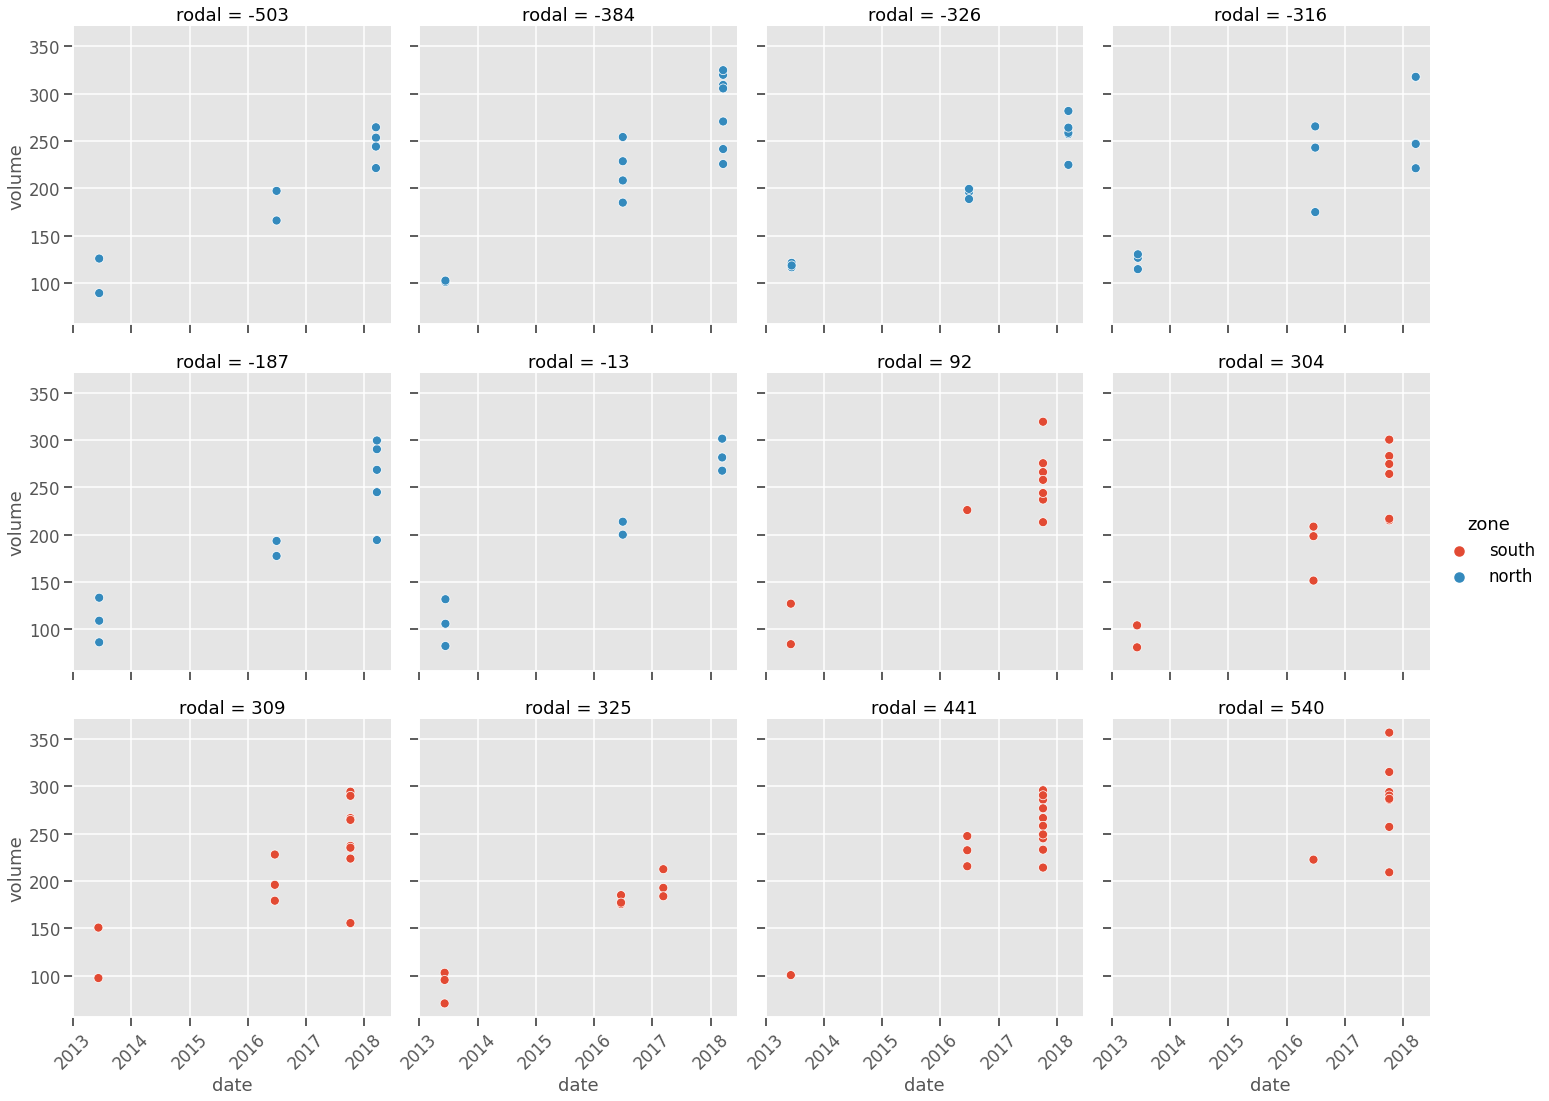

In [13]:
# We select the 20 rodals with the most measurements
selected_rodals = df["rodal"].value_counts().index[:12]

with sns.plotting_context("talk"):
    g = sns.relplot(
        data=df[df["rodal"].isin(selected_rodals)],
        hue="zone",
        x="date",
        y="volume",
        col="rodal",
        col_wrap=4,
    )
    g.set_xticklabels(rotation=45)
    plt.savefig(output_path/"volume_by_rodal.png")

You might have noticed that the rodals in the north have negative ids. This is because there were some cases where two rodals in different zones had the same number. Since a rodal is a geographical unit, it doesn't have any meaning without its associated zone, which is why to distinguish rodals from different zones, the northern ones have negative ids.

As we can see, even in a single rodal, volume measurements have a lot of variance. The upward trend is still very clear, though.

As a sanity check, we can check whether no matter the rodal, the mean of the measurements moves upward between each successive measurement date.

In [14]:
diffs = (
    df
    .groupby(["rodal", "date"])
    ["volume"]
    .mean()
    .unstack()
    .apply(lambda srs: srs.dropna().diff().reset_index(drop=True), axis=1)
)

rodals_going_down = diffs.index[(diffs < 0).any(1)].tolist()

print(f"Number of rodals that go down in volume from one year to the next: {len(rodals_going_down)} / {len(diffs)}")
df[df["rodal"].isin(rodals_going_down)].sort_values(["rodal", "date"])[["zone", "rodal", "date", "volume"]]

Number of rodals that go down in volume from one year to the next: 3 / 302


,zone,rodal,date,volume
525,north,-715,2016-06-29,247.6
796,north,-715,2018-03-15,231.5
561,north,-257,2013-06-13,104.5
559,north,-257,2016-06-29,134.1
759,north,-257,2018-03-22,99.8
218,south,191,2013-06-08,122.9
106,south,191,2016-06-18,210.6
423,south,191,2017-03-04,193.5


Only in 3 rodals does the volume go down on average from one year to the next, and those have very few samples (max one per year). So the measurements may be noisy, but they pass a basic sanity check.

# Basal area, volume

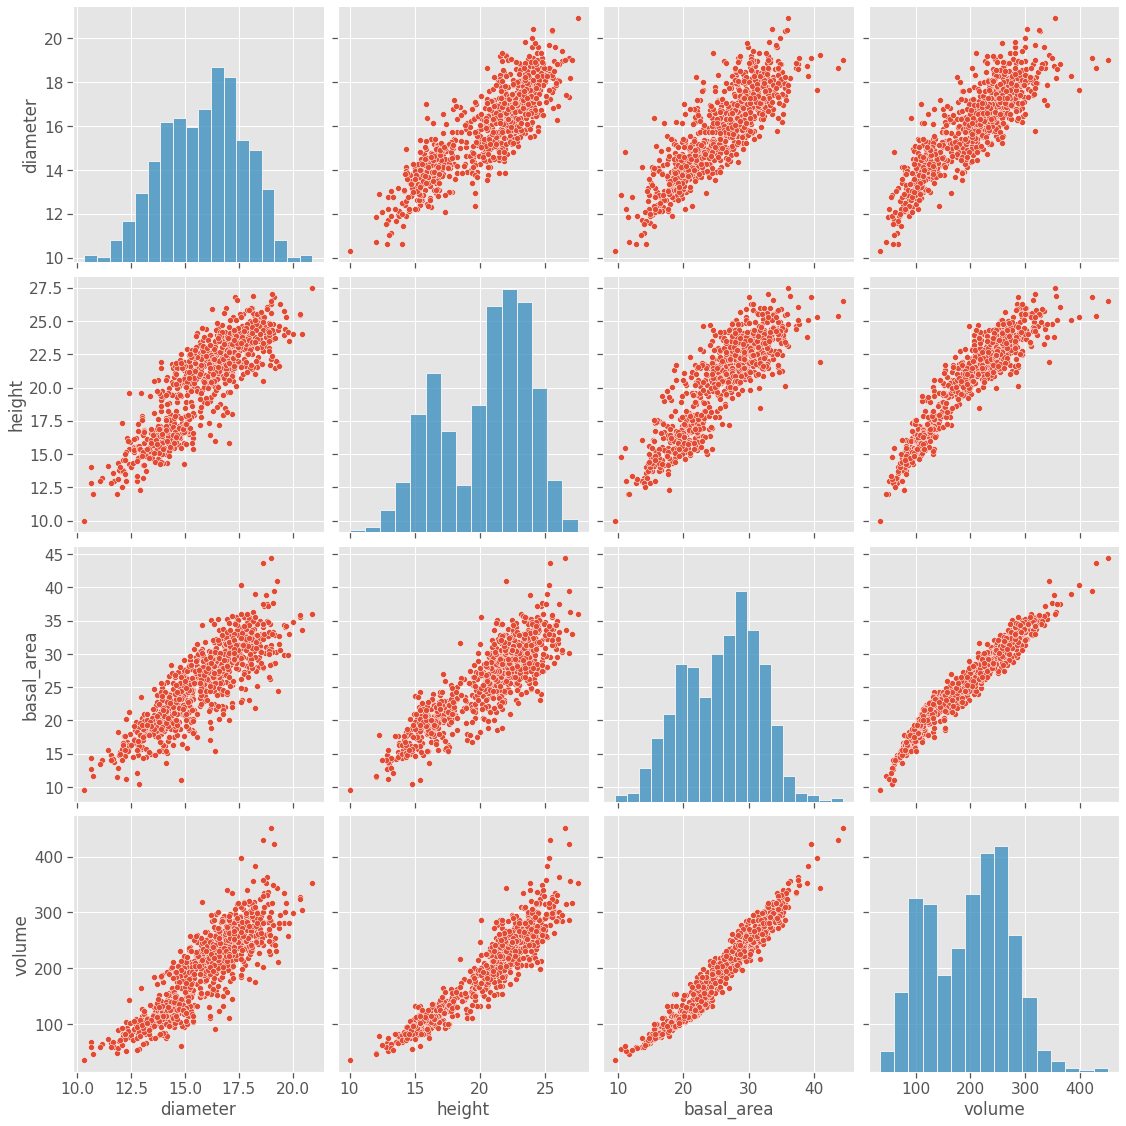

In [16]:
g = sns.pairplot(df[["diameter", "height", "basal_area", "volume"]], height=4)
plt.savefig(output_path/"pairplot.png")

In [26]:
print((df[["diameter", "height", "basal_area", "volume"]].corr()**2).round(2).to_markdown())

|            |   diameter |   height |   basal_area |   volume |
|:-----------|-----------:|---------:|-------------:|---------:|
| diameter   |       1    |     0.73 |         0.71 |     0.75 |
| height     |       0.73 |     1    |         0.75 |     0.87 |
| basal_area |       0.71 |     0.75 |         1    |     0.95 |
| volume     |       0.75 |     0.87 |         0.95 |     1    |
